In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.few_shot.datasets.omniglot import OmniglotSet
from torchlake.few_shot.models import (PrototypicalNetwork,
                                       PrototypicalNetworkLoss)
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
BATCH_SIZE = 16
SET_SIZE = 1000

In [3]:
artifact_path = Path('../../artifacts/prototypical')
data_path = Path('../../data')

In [4]:
device = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

In [6]:
train_dataset = OmniglotSet(
    data_path.as_posix(),
    SET_SIZE,
    preprocess,
    language="Armenian",
    enable_kshot=True,
    shot_size=1,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [48]:
model = PrototypicalNetwork(1).to(device)

In [31]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PrototypicalNetwork                      --
├─Sequential: 1-1                        --
│    └─ConvBnRelu: 2-1                   --
│    │    └─Conv2d: 3-1                  576
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
│    └─ConvBnRelu: 2-3                   --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-3                        --
│    └─ConvBnRelu: 2-5                   --
│    │    └─Conv2d: 3-7                  36,864
│    │    └─BatchNorm2d: 3-8             128
│    │    └─ReLU: 3-9                    --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-4                        --
│    └─ConvBnRelu: 2-7                   --
│    │    └─Con

# training

In [49]:
criterion = PrototypicalNetworkLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [50]:
epoch = 15

In [51]:
training_loss = []

model.train()
for e in range(epoch):
    running_loss = 0.0

    for query_set, support_set, label in tqdm(train_loader):
        optim.zero_grad()

        query_set = query_set.to(device)
        support_set = support_set.to(device)      
        label = label.long().to(device)
        
        output = model(query_set, support_set)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        running_loss += loss.item()

    mean_loss = running_loss / len(train_dataset)
    print(f"epoch:{e+1}, loss: {mean_loss}")
    training_loss.append(mean_loss)

100%|██████████| 62/62 [00:32<00:00,  1.88it/s]


epoch:1, loss: 0.3975933518409729


100%|██████████| 62/62 [00:32<00:00,  1.92it/s]


epoch:2, loss: 0.2955973339080811


100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


epoch:3, loss: 0.27416937971115113


100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


epoch:4, loss: 0.2634942774772644


100%|██████████| 62/62 [00:39<00:00,  1.56it/s]


epoch:5, loss: 0.2574491152763367


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


epoch:6, loss: 0.252795419216156


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


epoch:7, loss: 0.24951330041885375


100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


epoch:8, loss: 0.24721423029899597


100%|██████████| 62/62 [00:42<00:00,  1.46it/s]


epoch:9, loss: 0.24523544788360596


100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


epoch:10, loss: 0.2438763256072998


100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


epoch:11, loss: 0.24245273399353026


100%|██████████| 62/62 [00:32<00:00,  1.92it/s]


epoch:12, loss: 0.2413475091457367


100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


epoch:13, loss: 0.2404642596244812


100%|██████████| 62/62 [00:32<00:00,  1.91it/s]


epoch:14, loss: 0.23944227957725525


100%|██████████| 62/62 [00:32<00:00,  1.92it/s]

epoch:15, loss: 0.23878949236869812


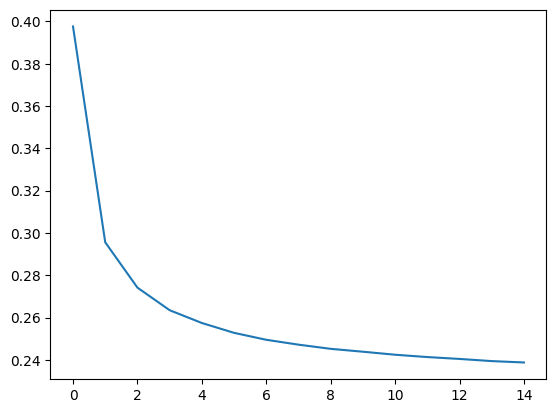

In [52]:
plt.plot(training_loss)

# evaluation

In [53]:
count = 0

model.eval()
with torch.no_grad():
    for query_set, support_set, label in tqdm(train_loader):
        query_set = query_set.to(device)
        support_set = support_set.to(device)      
        label = label.long().to(device)
        
        output = model(query_set, support_set).argmin(-1)
        count += torch.sum(output == label).item()

    print("acc", ":", count / len(train_dataset))

100%|██████████| 62/62 [00:30<00:00,  2.03it/s]

acc : 0.196


In [54]:
model_path = artifact_path / 'prototypical.pth'

In [55]:
torch.save(model.state_dict(), model_path)

In [56]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>